# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)


# Download modules

In [1]:
import os
import random
import copy
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import pickle
from pathlib import Path
import PIL
#from PIL import Image
from tqdm import tqdm, tqdm_notebook

import numpy as np
import pandas as pd
import sklearn
#from skimage import io
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import albumentations as A
import albumentations.pytorch
import cv2

from matplotlib import colors, pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import GPUtil
from GPUtil import showUtilization as gpu_usage

In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [3]:
def set_random(n):
    random.seed(n)
    np.random.seed(n)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
    torch.backends.cudnn.deterministic = True
    
set_random(42)

In [4]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

In [5]:
# работаем на видеокарте
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
# Укажем путь, где находятся файлы для train и валидации
TRAIN_DIR = Path('./journey-springfield/train/')
TEST_DIR = Path('./journey-springfield/testset/testset')

In [7]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

# Анализ даных

Посмотрим, что у нас там вообще есть

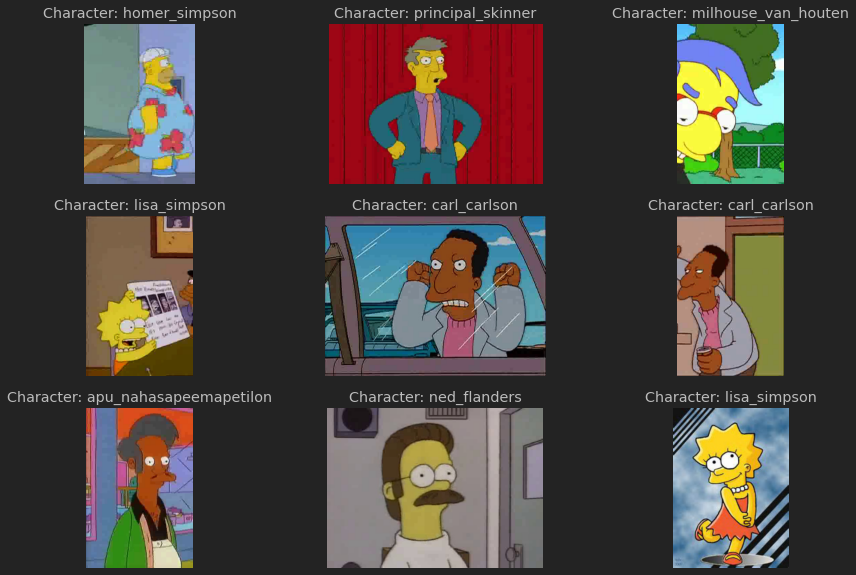

In [8]:
# Load pics
plt.figure(figsize = (15,10))
for i in range(9):
    rand_idx = int(np.random.uniform(0,20000))
    im = PIL.Image.open(train_val_files[rand_idx])
    plt.subplot(3, 3, i + 1)
    plt.imshow(im)
    label = (train_val_files[rand_idx]).parent.name
    plt.title('Character: ' + str(label))
    plt.axis('off')
plt.show()

## Распределение классов

Посмотрим на распределение классов в выборке. Сбалансированно ли оно?

In [9]:
def proccess_img(files):
    '''Function is called to create a dataframe with 
    filepath and the labels of the picture'''
    #files = sorted(list(filepath.rglob('*.jpg')))
    labels = [path.parent.name for path in files]
    path = [str(path) for path in files]
    filepath = pd.Series(path, name='Filepath')
    labels = pd.Series(labels, name='Label')
    # concatenate filepaths and lables
    df = pd.concat([filepath, labels], axis = 1)
    # shuffle the dataframe and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [10]:
# Создадим датафрэйм
df = proccess_img(train_val_files)

In [11]:
# выведем количество данных
print(f'Number of pictures in trainset: {df.shape[0]}')
print(f'Number of unique labels: {len(df.Label.unique())}')

df.sample(2)

Number of pictures in trainset: 20933
Number of unique labels: 42


,Filepath,Label
2224,journey-springfield/train/simpsons_dataset/abr...,abraham_grampa_simpson
20007,journey-springfield/train/simpsons_dataset/com...,comic_book_guy


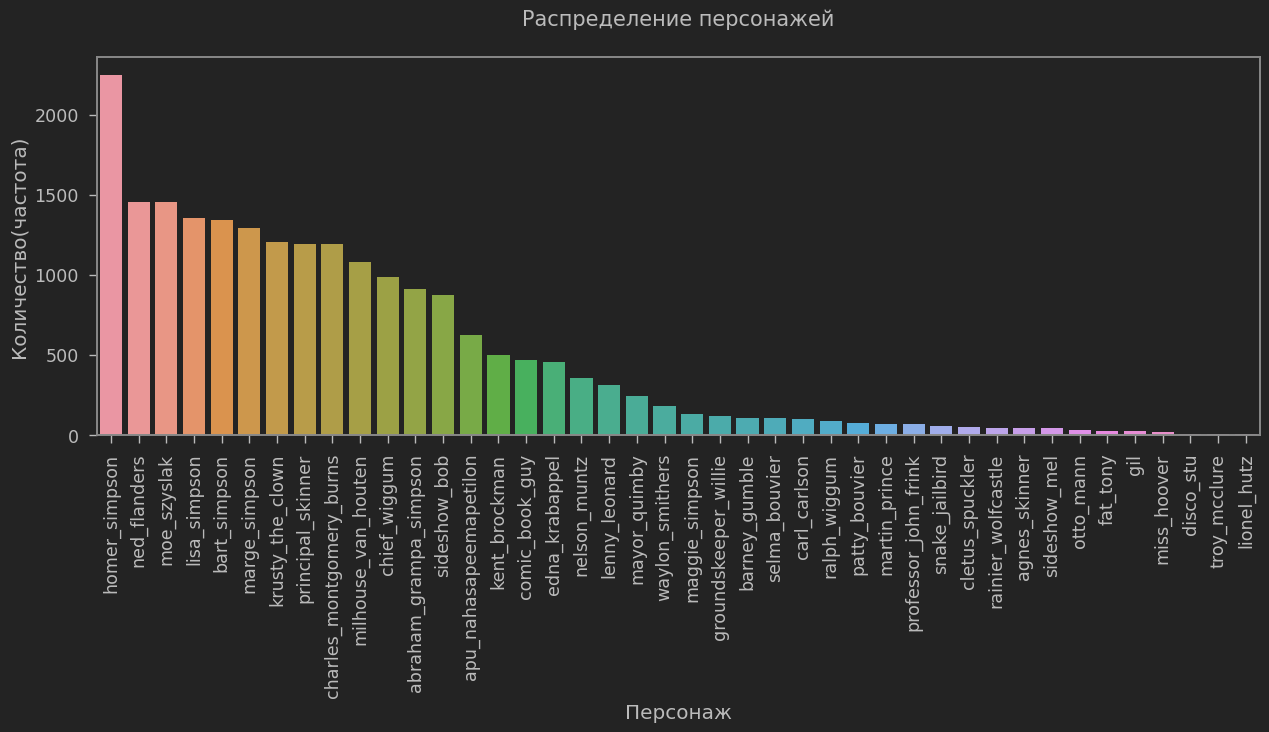

In [12]:
# Напечатаем распределение
plt.figure(figsize=(15,5), dpi=100)
sns.countplot(x=df['Label'], 
              order=df['Label'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Распределение персонажей\n', fontsize=15)
plt.xlabel('Персонаж')
plt.ylabel('Количество(частота)')
plt.show()

Видно, что данные сильно дисбалансны. 

Попробуем это исправить

## Дisbalance

In [13]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.3, \
                                          stratify=train_val_labels)
print(f'Val files num: {len(val_files)}')
print(f'train_files num: {len(train_files)}')
print(f'test_files num: {len(test_files)}')

Val files num: 6280
train_files num: 14653
test_files num: 991


Код взят из комментариев на степике.

Основная идея в том, что-бы увеличить вероятность попадания редких классов в

даталоадеры при тренировке.

Это достигается путем копирования путей к файлам, а не самих файлов.

Во время экспериментов был опробован готовый модуль по оверсэмплингу:

https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

Но у меня почему-то не получилось ее применить и было решено взять код Антон Дмитриевич Ширяев

In [14]:
# Код взят из комментариев на степике (Антон Дмитриевич Ширяев)
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [15]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [16]:
# Создадим словарь в котором ключами будут персонажи
# Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)
dct_path_train['bart_simpson'][0]

PosixPath('journey-springfield/train/simpsons_dataset/bart_simpson/pic_0530.jpg')

In [17]:
# Дополним картинки классов у которых менее 150 картинок, до 300 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 150:
        dct_path_train[person] = dct_path_train[person] * (300 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:300 - len(dct_path_train[person])])

In [18]:
# # Проверим что получилось 
# for person in dct_path_train:
#     print(f"{person}\t{len(dct_path_train[person])}")

In [19]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

In [20]:
def print_dct(dct_simpsons):
    '''print dictionary'''
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [21]:
def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

In [22]:
# выведим на печать класс:количесвто картинок после наших манипуляций
print_dct(create_dct_from_labels(new_train_label))

abraham_grampa_simpson	639
agnes_skinner	300
apu_nahasapeemapetilon	436
barney_gumble	300
bart_simpson	939
carl_carlson	300
charles_montgomery_burns	835
chief_wiggum	690
cletus_spuckler	300
comic_book_guy	328
disco_stu	300
edna_krabappel	320
fat_tony	300
gil	300
groundskeeper_willie	300
homer_simpson	1572
kent_brockman	349
krusty_the_clown	844
lenny_leonard	217
lionel_hutz	300
lisa_simpson	948
maggie_simpson	300
marge_simpson	904
martin_prince	300
mayor_quimby	172
milhouse_van_houten	755
miss_hoover	300
moe_szyslak	1016
ned_flanders	1018
nelson_muntz	251
otto_mann	300
patty_bouvier	300
principal_skinner	836
professor_john_frink	300
rainier_wolfcastle	300
ralph_wiggum	300
selma_bouvier	300
sideshow_bob	614
sideshow_mel	300
snake_jailbird	300
troy_mcclure	300
waylon_smithers	300


Теперь данные сбалансированны лучше.

Во время выполнения работы были проведены эксперименты с дисбалансными данными и балансными.

В целом, балансные данные лучше считаются моделями и на выходе получается бОльший F1.

В данном ноутбуке эксперементы не приводятся для удобства проверяющего.

In [23]:
# Создадим дф с классами и...
df = proccess_img(new_train_files)

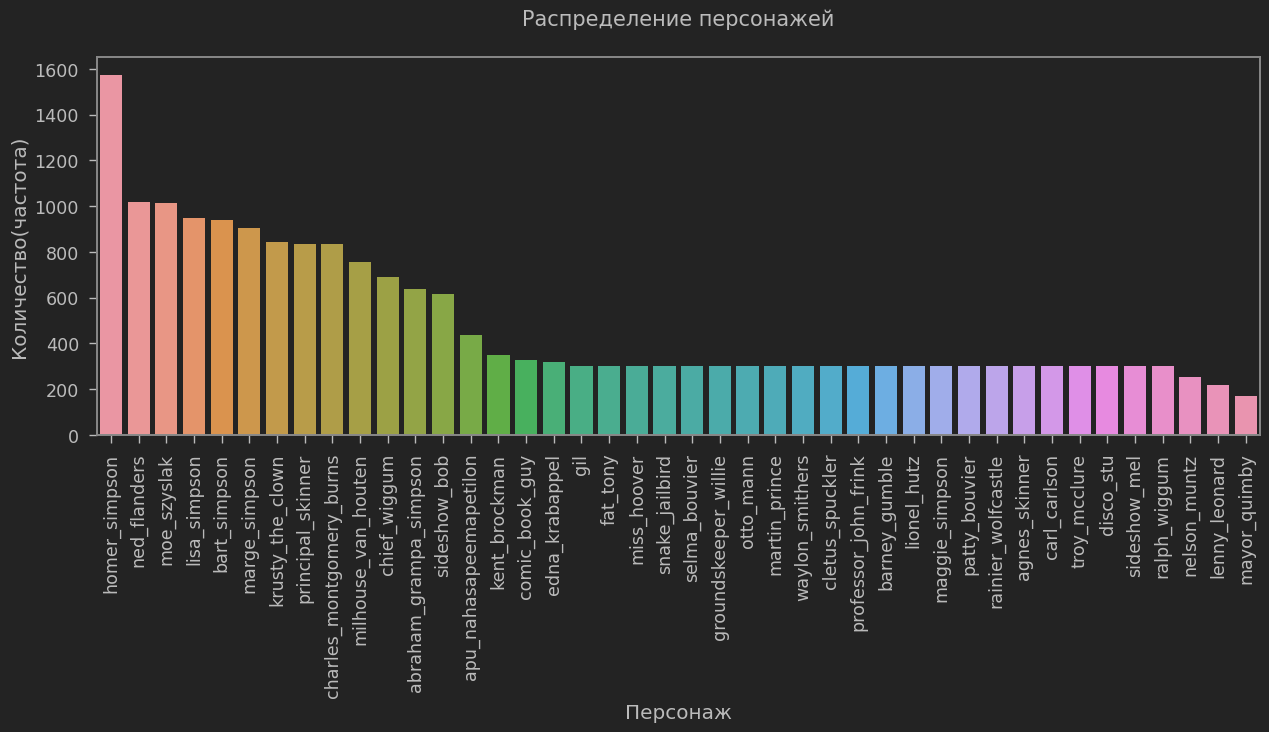

In [24]:
# ... Посмотрим на распределение
plt.figure(figsize=(15,5), dpi=100)
sns.countplot(x=df['Label'], 
              order=df['Label'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Распределение персонажей\n', fontsize=15)
plt.xlabel('Персонаж')
plt.ylabel('Количество(частота)')
plt.show()

Все получилось

# Определение классов и функций для тренировки сетей

## Basic

Немного изменим класс SimpsonsDataset данный в бэйслайне

 - Я решил использовать cv2.imread вместо PIL.Image. У меня возникли какие-то проблемы с PIL
 
 - Метод _prepare_sample удален. Ресайз будет включен в трансформации

In [25]:
class SimpsonsDataset(Dataset):
    '''Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры'''
    def __init__(self, files, mode, transform=None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # Mode
        self.mode = mode
        self.transform = transform
        
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        
        self.len_ = len(self.files)
        
        self.label_encoder = LabelEncoder()
        
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)
    
    def __len__(self):
        return self.len_
    
    def load_sample(self, file):
#         image = Image.open(file)
#         image.load()
        image = cv2.imread(str(file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    def __getitem__(self, index):
        '''
        Преобразование входной картинки
        Данные среднего и стандартного отклонения взяты из ImageNet
        '''
        x = self.load_sample(self.files[index])
        if self.transform is not None:
            x = self.transform(image = x)["image"]
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [26]:
def fit_epoch(model, 
              train_loader, 
              criterion, 
              optimizer,
              scheduler):
    
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    # Выведем инфу по исп. CUDA  до прогона
    print("Initial GPU Usage at fit_epoch")
    gpu_usage()
    
    for inputs, labels in train_loader:
        #inputs = inputs.half()
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, 1)
        
        loss.backward()
        optimizer.step()
        #scheduler.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        del inputs, outputs
        torch.cuda.empty_cache()
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    #del running_corrects, processed_data, running_loss
    
    # Выведем инфу по исп. CUDA  посде прошгона и очистки кэша
    torch.cuda.empty_cache()
    print("GPU Usage after placing bunch of tensors in fit_epoch")
    gpu_usage()
    return train_loss, train_acc

In [27]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        #inputs = inputs.half()
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        del inputs, outputs
        torch.cuda.empty_cache()
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double().cpu() / processed_size
    return val_loss, val_acc

In [28]:
%%script False

# Посмотрим, какое количество воркеров оптимально для нашей машины
import time
pin_memory = True
print('pin_memory is', pin_memory)
 
for num_workers in range(0, 12, 1): 
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
    num_workers=num_workers, pin_memory=pin_memory)
    start = time.time()
    for epoch in range(1, 5):
        for i, data in enumerate(train_loader):
            pass
    end = time.time()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

Couldn't find program: 'False'


In [29]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True,
                              pin_memory=True,
                              num_workers=4) # pc -8 lap =4
    val_loader = DataLoader(val_dataset, 
                            batch_size=batch_size, 
                            shuffle=False,
                            pin_memory = True,
                            num_workers = 4) # pc -8 lap =4

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                                    step_size=5, 
                                                    gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            torch.cuda.empty_cache()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            #del train_loss,train_acc,val_loss,val_acc
            torch.cuda.empty_cache()
            
    return history

In [30]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Функции для метрик

Что-бы оценивать наши модельки, напишем пару функций для извлечения метрик

In [31]:
def get_all_preds(model=None, X_val=None, y_val=None, dataset=None):
    '''
    Функция возвращает:
    y_pred - вероятность (float)
    actual_labels - Принадлежность к классу (int)
    preds_class - предсказанный Класс (str)
    actual_class - истинный класс (str)
    '''
    idxs = list(map(int, range(len(dataset))))
    imgs = [dataset[id][0].unsqueeze(0) for id in idxs]
    # get all predictions along output neurons
    probs_ims = predict(model, imgs)
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    #probs = np.max(probs_ims,-1)
    # get predicted class proba
    y_pred = np.argmax(probs_ims,-1)
    actual_labels = np.array([dataset[id][1] for id in idxs])
    #predictions in string format
    preds_class = [label_encoder.classes_[i] for i in y_pred]
    #actual lables in string format
    actual_class = [label_encoder.classes_[i] for i in actual_labels]
    
    return y_pred, actual_labels, preds_class, actual_class

In [32]:
def get_scores(report_df, y_true, y_hat, name):
    '''Create and add metrics into a pandas DF after experiment'''
    
    rep_dict = sklearn.metrics.classification_report(y_true,y_hat, zero_division=1,output_dict=True)

    report = pd.DataFrame(columns={'F1_micro'}, data=[0])
    
    report['F1_micro'] = f1_score(y_true, y_hat,average='micro')
    report['F1_macro'] = rep_dict['macro avg']['f1-score']
    report['precision_macro'] = rep_dict['macro avg']['precision']
    report['recall_macro'] = rep_dict['macro avg']['recall']
    report.index = [name]
    report_df = report_df.append(report)
    return report_df

In [33]:
def plot_class_report(y_true, y_hat):
    '''Возвращает отчет с метриками классификации'''
    report_1 = sklearn.metrics.classification_report(y_true,y_hat, zero_division=1)
    print('\n', report_1)

In [34]:
def confusion_mtx(actual_label, predicted_label):
    '''Строит матрицу Концуция :)'''
    df = pd.DataFrame({'actual_lab':actual_label, 'pred_lab': predicted_label})
    confusion_mtx = pd.crosstab(df['actual_lab'], 
                                df['pred_lab'], 
                                rownames=['Actual'], 
                                colnames=['Predicted'], 
                                margins = False)
    
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    yticklabels = label_encoder.classes_
    
    plt.subplots(figsize=(20,20))
    print(f'Quantity of labels in validation dataset: {confusion_mtx.shape[0]}')
    print(f'Quantity of predicted labels: {confusion_mtx.shape[1]}')
    
    sns.heatmap(confusion_mtx, annot=True, 
                fmt="d", linewidths=0.5, 
                cmap="YlGnBu", cbar=False, 
                vmax = 30, yticklabels=yticklabels, 
                xticklabels=yticklabels);

In [35]:
def plot_loss_acc(history):
    """Печатает лосс и точность"""
    loss, acc, val_loss, val_acc = zip(*history)

    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
    fig.suptitle('Loss and Accuracy')
    ax1.plot(loss, label="train_loss")
    ax1.plot(val_loss, label="val_loss")
    ax1.legend(loc='best')
    plt.ylabel("loss")

    ax2.plot(acc, label="train_accuracy")
    ax2.plot(val_acc, label="val_accuracy")
    ax2.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

In [36]:
def accurancy_for_each_class(y_test_all, predictions_all,classes_number=42):
    """Точность для каждого предсказанного класса"""
    class_correct = [0 for i in range(classes_number)]
    class_total = [0 for i in range(classes_number)]
    feature_names = sorted(set(dataloaders['val'].dataset.labels))

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]            
        class_correct[label] += c[i].item()
        class_total[label] += 1

    #print(class_total)
    #print(len(class_total))

    for i in range(classes_number):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

# Строим BaseLine

## Перед строительством добавим аугментаций

In [37]:
def get_augmentation(pic_size,mode):
    if mode !='train':
        augmentation_test = albumentations.Compose([A.Resize(pic_size,pic_size),
                                                    A.Normalize(
                                                        mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225]),
                                                    A.pytorch.transforms.ToTensorV2()])
        return augmentation_test
    else:
        augmentation_train = A.Compose([
            A.Resize(pic_size,pic_size),
            A.RandomCrop(pic_size, pic_size),
            A.OneOf([
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.VerticalFlip(p=0.5)], p=0.5),
            A.OneOf([
                A.GaussNoise(),], p=0.2),
            A.OneOf([
                A.MotionBlur(p=0.2),
                A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),], p=0.8),
            A.ShiftScaleRotate(
                shift_limit=0.0625, 
                scale_limit=0.2, 
                rotate_limit=15, p=1),
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=0.1),], p=0.8),
            A.OneOf([
                A.CLAHE(clip_limit=2),
                A.RandomBrightnessContrast(),], p=0.5),
            A.HueSaturationValue(p=0.3),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
            A.pytorch.transforms.ToTensorV2()], p=1)
        return augmentation_train

In [38]:
# Создадим датасет для визуализации аугментаций

val_dataset = SimpsonsDataset(val_files,
                                  mode='train', 
                                  transform=get_augmentation(224,'train'))

In [39]:
def visualize_augmentations(dataset, idx=6, samples=15, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, A.pytorch.ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

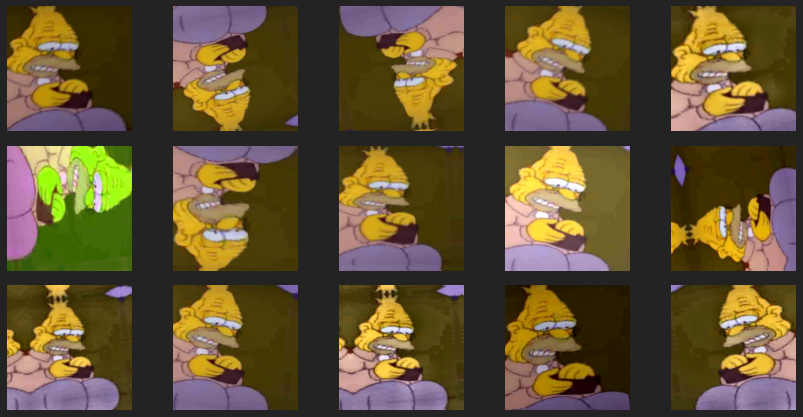

In [40]:
visualize_augmentations(val_dataset)

In [41]:
del val_dataset

# Transfer Learning

Напишем функцию для инициализации разных архитектур моделей

И Затем сравним их performance 

In [42]:
def initialize_model(model_name,
                     num_classes,
                     use_pretrained=True):
    
    model = None
    input_size = 0
    count = 0
       
    if model_name == "resnet50":
        """ Resnet50
        """
        model = models.resnet50(pretrained=use_pretrained)
        # Заморозим первые 6 слоев
        for child in model.children():
            count+=1
            if count < 7:
                for param in child.parameters():
                    param.requires_grad = False
                    
        num_ftrs = model.fc.in_features
        # на последний слой, устанавливаем необходимый выход
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == 'resnext-101-32x8d':
        """ ResNeXt-101-32x8d
        """
        model = models.resnext101_32x8d(pretrained=use_pretrained)
        # Заморозим первые 6 слоев
        for child in model.children():
            count+=1
            if count < 8:
                for param in child.parameters():
                    param.requires_grad = False
                    
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    
    elif model_name == 'googlenet':
        '''googlenet'''
        model = models.googlenet(pretrained=use_pretrained)
        # Заморозим 8 из 16 чилдренов
        for i, child in enumerate(model.children()):
            if i not in [x for x in range(9,17)]:
                for param in child.parameters():
                    param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == 'inception':
        '''inception'''
        model = models.inception_v3(pretrained=use_pretrained)
        # Заморозим первые 18 слоев
        for child in model.children():
            count+=1
            if count < 18:
                for param in child.parameters():
                    param.requires_grad = False
        input_size = 229
    
    elif model_name == 'densenet161':
        model = models.densenet161(pretrained=use_pretrained)
        for child in model.children():
            for param in child.parameters():
                count+=1
                if count <400:
                    param.requires_grad = False
        
        
    else:
        print("Invalid model name, exiting...")
        exit()

    return model, input_size

## Подготовим данные

### Настройка сетки

In [43]:
# Перечислим доступные нам архитектуры
model_name = [
    "resnet50",
    'resnext-101-32x8d',
    'googlenet',
    'inception',
    'densenet161'
]

# Определяем количество классов
n_classes = len(np.unique(train_val_labels))
print(f'Количество классов в датасете: {n_classes}')

# Задаем количество эпох
epochs = 15

# Размер ставлю 16. Я не очень понимаю, но почему-то на 2070 ошибки вылазять чаще чем на 1060
# На 16 их меньше
batch_size = 16

Количество классов в датасете: 42


In [44]:
# Возьмем первую архитектуру из списка
model_arch = model_name[0]

### Инициализация модели и датасета

In [45]:
# Model
model, input_size = initialize_model(model_arch,n_classes,)

In [46]:
# Инициализируем датасеты

val_dataset = SimpsonsDataset(val_files,
                                  mode='val', 
                                  transform=get_augmentation(input_size,'val'))
# Используем сбалансированный по лейблам сет 
balanced_train_dataset = SimpsonsDataset(new_train_files, 
                                    mode='train', 
                                    transform=get_augmentation(input_size,'train'))

In [47]:
model = model.to(DEVICE)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [48]:
# # Посмотрим, какие слои мы будем обучать
# params_to_update = []
# for name, param in model.named_parameters():
#     if param.requires_grad == True:
#         params_to_update.append(param)
#         print(name)

### Тренировка модели_1

In [49]:
history = train(balanced_train_dataset, 
                val_dataset, 
                model=model, 
                epochs=epochs,
                batch_size=batch_size)

epoch:   0%|                                                                                                                                                                                                                                                                                     | 0/15 [00:00<?, ?it/s]

Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 18% | 24% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 81% | 35% |
loss 2.390419112603375


epoch:   7%|█████████████████▊                                                                                                                                                                                                                                                          | 1/15 [02:18<32:19, 138.52s/it]


Epoch 001 train_loss: 2.3904     val_loss 0.9253 train_acc 0.3720 val_acc 0.7561
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 35% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 79% | 35% |
loss 3.4354646595743454


epoch:  13%|███████████████████████████████████▋                                                                                                                                                                                                                                        | 2/15 [04:31<29:15, 135.05s/it]


Epoch 002 train_loss: 3.4355     val_loss 1.2595 train_acc 0.2535 val_acc 0.6732
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 35% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 82% | 35% |
loss 1.2248633184747066


epoch:  20%|█████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 3/15 [06:43<26:46, 133.90s/it]


Epoch 003 train_loss: 1.2249     val_loss 0.6463 train_acc 0.6712 val_acc 0.8256
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 85% | 35% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 76% | 35% |
loss 0.7725575779931688


epoch:  27%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 4/15 [08:57<24:30, 133.69s/it]


Epoch 004 train_loss: 0.7726     val_loss 0.5245 train_acc 0.7908 val_acc 0.8583
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 35% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 82% | 34% |
loss 0.5950870937257983


epoch:  33%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                  | 5/15 [11:10<22:15, 133.58s/it]


Epoch 005 train_loss: 0.5951     val_loss 0.4430 train_acc 0.8390 val_acc 0.8917
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 34% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 82% | 34% |
loss 0.5076739982043075


epoch:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                | 6/15 [13:23<20:01, 133.51s/it]


Epoch 006 train_loss: 0.5077     val_loss 0.3598 train_acc 0.8630 val_acc 0.9084
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 34% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 82% | 34% |
loss 0.42731514377966257


epoch:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 7/15 [15:36<17:47, 133.40s/it]


Epoch 007 train_loss: 0.4273     val_loss 0.3764 train_acc 0.8836 val_acc 0.9061
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 34% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 82% | 41% |
loss 0.39868823001978987


epoch:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 8/15 [17:47<15:26, 132.40s/it]


Epoch 008 train_loss: 0.3987     val_loss 0.3742 train_acc 0.8914 val_acc 0.9049
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 85% | 41% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 81% | 41% |
loss 0.34915042582845884


epoch:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/15 [19:59<13:14, 132.40s/it]


Epoch 009 train_loss: 0.3492     val_loss 0.3758 train_acc 0.9033 val_acc 0.9089
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 85% | 41% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 82% | 41% |
loss 0.3277754077806967


epoch:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 10/15 [22:12<11:02, 132.44s/it]


Epoch 010 train_loss: 0.3278     val_loss 0.3088 train_acc 0.9092 val_acc 0.9239
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 41% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 82% | 41% |
loss 0.29422982415120186


epoch:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11/15 [24:25<08:50, 132.61s/it]


Epoch 011 train_loss: 0.2942     val_loss 0.2822 train_acc 0.9192 val_acc 0.9323
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 84% | 40% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 84% | 39% |
loss 0.2836709973644163


epoch:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 12/15 [26:39<06:39, 133.23s/it]


Epoch 012 train_loss: 0.2837     val_loss 0.2928 train_acc 0.9216 val_acc 0.9315
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 39% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 78% | 39% |
loss 0.2654249751704589


epoch:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 13/15 [28:52<04:26, 133.17s/it]


Epoch 013 train_loss: 0.2654     val_loss 0.2731 train_acc 0.9270 val_acc 0.9318
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 39% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 81% | 39% |
loss 0.25013806678487255


epoch:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 14/15 [31:06<02:13, 133.32s/it]


Epoch 014 train_loss: 0.2501     val_loss 0.2981 train_acc 0.9289 val_acc 0.9264
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 39% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 79% | 40% |
loss 0.23317192699123798


epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [33:18<00:00, 133.26s/it]


Epoch 015 train_loss: 0.2332     val_loss 0.2646 train_acc 0.9357 val_acc 0.9411


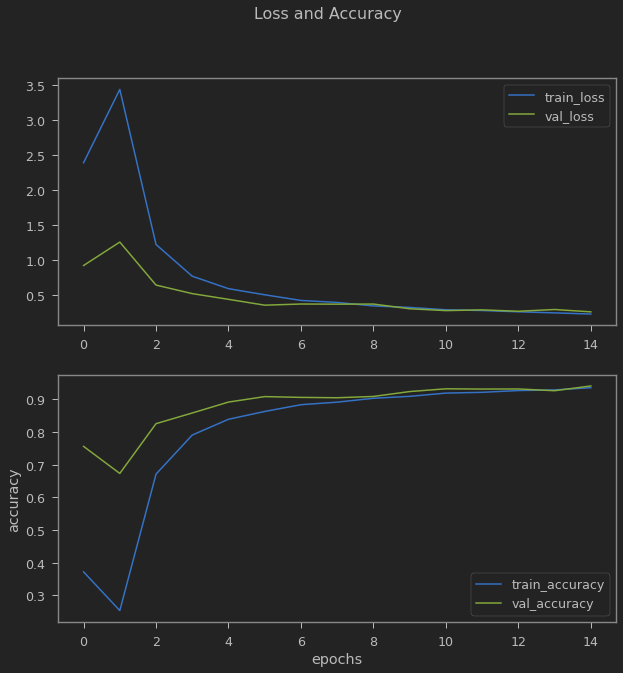

In [50]:
# Напечатаем лосс и точность
plot_loss_acc(history)

In [51]:
# Посчитаем предсказания
y_pred, actual_labels, preds_class, actual_class = get_all_preds(model,
                                                                 dataset=val_dataset)

In [52]:
# Посмотрим на метрики
plot_class_report(actual_class,preds_class)


                           precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.89      0.94       274
           agnes_skinner       1.00      1.00      1.00        13
  apu_nahasapeemapetilon       0.96      0.97      0.97       187
           barney_gumble       0.54      0.91      0.67        32
            bart_simpson       0.98      0.97      0.97       403
            carl_carlson       1.00      0.83      0.91        29
charles_montgomery_burns       0.97      0.89      0.93       358
            chief_wiggum       0.90      0.96      0.93       296
         cletus_spuckler       0.93      0.93      0.93        14
          comic_book_guy       0.97      0.82      0.89       141
               disco_stu       0.00      0.00      0.00         2
          edna_krabappel       0.99      0.91      0.95       137
                fat_tony       0.73      1.00      0.84         8
                     gil       0.86      0.75      0.80         8
    gro

In [53]:
BATCH_SIZE = 128
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(balanced_train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}

In [54]:
# Посмотрим на точности пределения классов
accurancy_for_each_class(actual_labels,y_pred)

Accuracy of abraham_grampa_simpson : 100 %
Accuracy of agnes_skinner : 100 %
Accuracy of apu_nahasapeemapetilon : 95 %
Accuracy of barney_gumble : 53 %
Accuracy of bart_simpson : 97 %
Accuracy of carl_carlson : 100 %
Accuracy of charles_montgomery_burns : 96 %
Accuracy of chief_wiggum : 89 %
Accuracy of cletus_spuckler : 92 %
Accuracy of comic_book_guy : 96 %
Accuracy of disco_stu :  0 %
Accuracy of edna_krabappel : 99 %
Accuracy of fat_tony : 72 %
Accuracy of   gil : 85 %
Accuracy of groundskeeper_willie : 78 %
Accuracy of homer_simpson : 93 %
Accuracy of kent_brockman : 99 %
Accuracy of krusty_the_clown : 95 %
Accuracy of lenny_leonard : 91 %
Accuracy of lionel_hutz : -1 %
Accuracy of lisa_simpson : 98 %
Accuracy of maggie_simpson : 89 %
Accuracy of marge_simpson : 97 %
Accuracy of martin_prince : 90 %
Accuracy of mayor_quimby : 86 %
Accuracy of milhouse_van_houten : 97 %
Accuracy of miss_hoover : 83 %
Accuracy of moe_szyslak : 93 %
Accuracy of ned_flanders : 88 %
Accuracy of nelson_

Видно, что не все классы определяются, хз что не так. 

Quantity of labels in validation dataset: 42
Quantity of predicted labels: 41


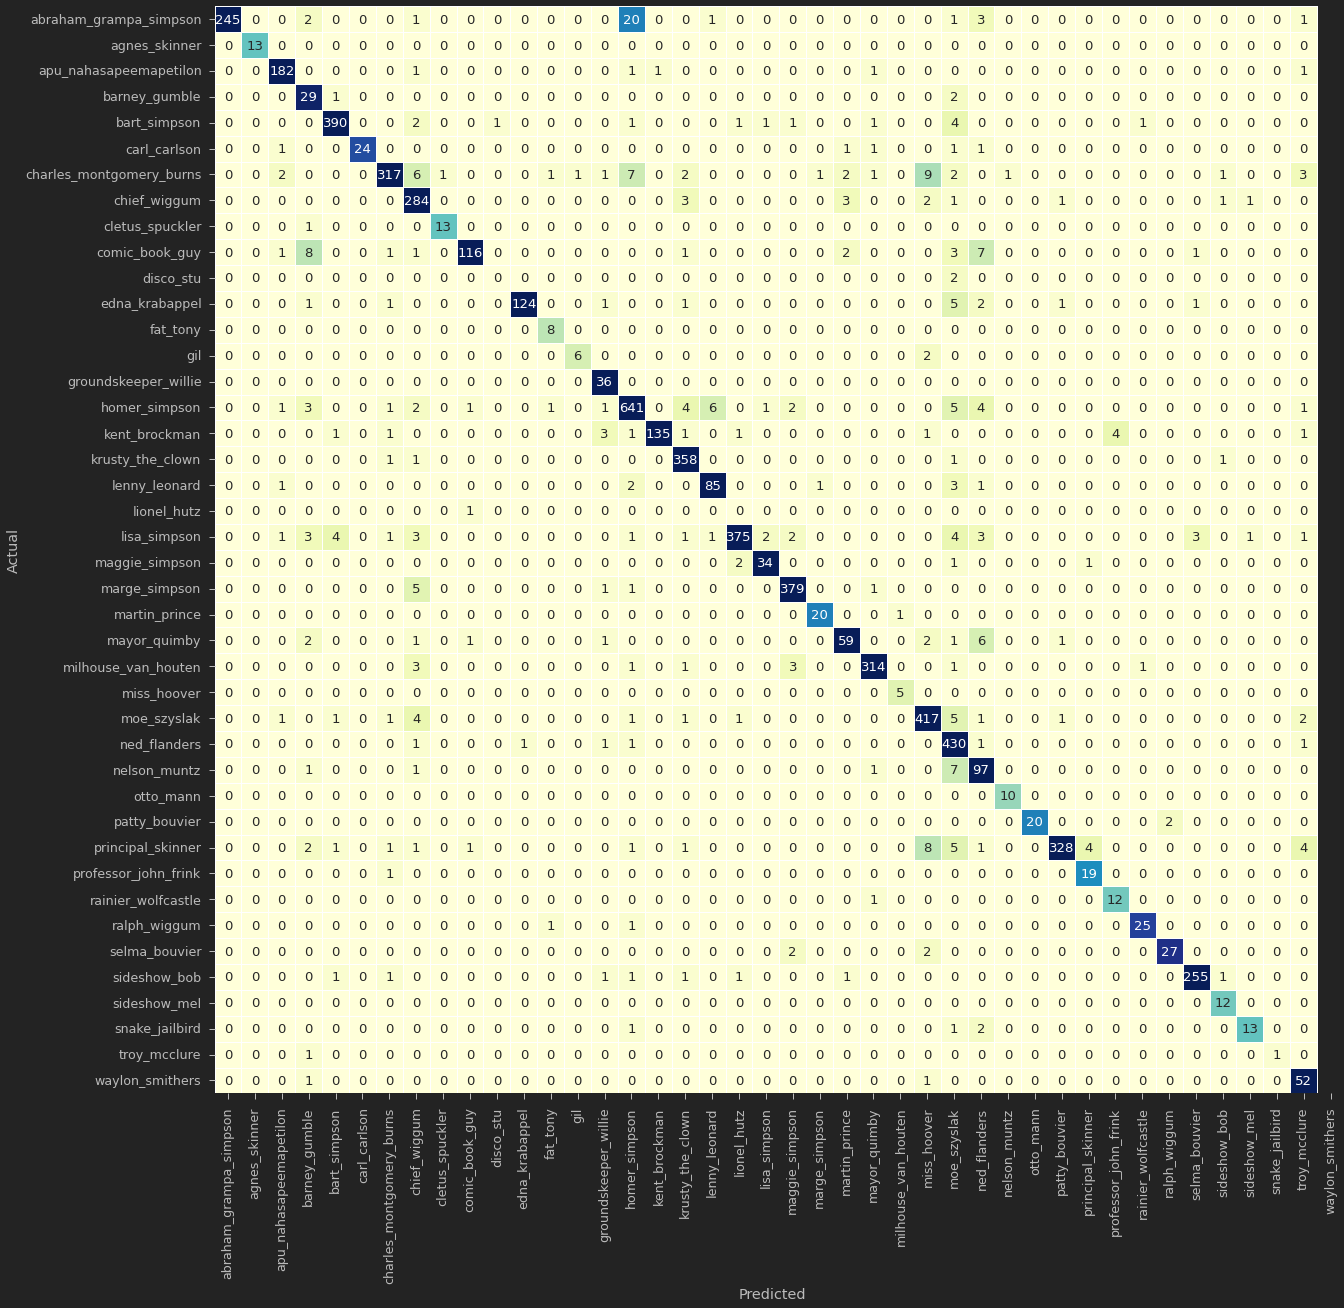

In [55]:
confusion_mtx(actual_class,preds_class)

In [56]:
# Сохраним в отчет
df_report = pd.DataFrame(data=None)
df_report = get_scores(df_report, actual_labels, y_pred,'Res_Net50')
df_report

,F1_micro,F1_macro,precision_macro,recall_macro
Res_Net50,0.941083,0.859345,0.882896,0.872347


In [57]:
# Сохраним веса обученных моделей
model_weights = copy.deepcopy(model.state_dict())
torch.save(model_weights, "./Res_net_model_weights.pth")

In [ ]:
# Загрузка весов
model.load_state_dict(torch.load("./Res_net_model_weights.pth"))

### Тренировка модели_2

In [69]:
model_arch = model_name[2]

In [70]:
# Model
model, input_size = initialize_model(model_arch,n_classes,)

In [ ]:
count = 0
for child in model.children():
    for param in child.parameters():
        print(param.requires_grad)
    count+=1
print(count)

In [71]:
model = model.to(DEVICE)
print(model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [72]:
history = train(balanced_train_dataset,
                val_dataset,
                model=model,
                epochs=epochs,
                batch_size=batch_size)


epoch:   0%|                                                                                                                                                                                                                                                                                     | 0/15 [00:00<?, ?it/s]

Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 |  0% | 65% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 59% | 36% |
loss 1.070989014522532


epoch:   7%|█████████████████▉                                                                                                                                                                                                                                                           | 1/15 [01:13<17:08, 73.47s/it]


Epoch 001 train_loss: 1.0710     val_loss 0.5122 train_acc 0.7137 val_acc 0.8576
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 66% | 36% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 53% | 36% |
loss 0.7051606972953516


epoch:  13%|███████████████████████████████████▊                                                                                                                                                                                                                                         | 2/15 [02:21<15:12, 70.21s/it]


Epoch 002 train_loss: 0.7052     val_loss 0.4656 train_acc 0.8067 val_acc 0.8801
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 62% | 36% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 54% | 36% |
loss 0.4273912597656829


epoch:  20%|█████████████████████████████████████████████████████▊                                                                                                                                                                                                                       | 3/15 [03:31<14:01, 70.12s/it]


Epoch 003 train_loss: 0.4274     val_loss 0.3462 train_acc 0.8837 val_acc 0.9116
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 62% | 36% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 54% | 36% |
loss 0.3659035860665317


epoch:  27%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 4/15 [04:42<12:53, 70.36s/it]


Epoch 004 train_loss: 0.3659     val_loss 0.3529 train_acc 0.9003 val_acc 0.9118
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 65% | 36% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 54% | 36% |
loss 0.3230799237211175


epoch:  33%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 5/15 [05:53<11:48, 70.82s/it]


Epoch 005 train_loss: 0.3231     val_loss 0.3069 train_acc 0.9133 val_acc 0.9236
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 62% | 35% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 55% | 35% |
loss 0.29344742591791056


epoch:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 6/15 [07:03<10:34, 70.52s/it]


Epoch 006 train_loss: 0.2934     val_loss 0.3264 train_acc 0.9206 val_acc 0.9202
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 61% | 35% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 53% | 35% |
loss 0.2743236897482966


epoch:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 7/15 [08:13<09:22, 70.34s/it]


Epoch 007 train_loss: 0.2743     val_loss 0.4553 train_acc 0.9255 val_acc 0.8914
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 60% | 35% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 56% | 35% |
loss 0.242467806444341


epoch:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 8/15 [09:24<08:14, 70.64s/it]


Epoch 008 train_loss: 0.2425     val_loss 0.3153 train_acc 0.9334 val_acc 0.9252
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 66% | 36% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 45% | 32% |
loss 0.2374197313853441


epoch:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 9/15 [10:36<07:04, 70.82s/it]


Epoch 009 train_loss: 0.2374     val_loss 0.3175 train_acc 0.9358 val_acc 0.9312
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 62% | 32% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 54% | 32% |
loss 0.22478898055335475


epoch:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 10/15 [11:45<05:52, 70.45s/it]


Epoch 010 train_loss: 0.2248     val_loss 0.2751 train_acc 0.9382 val_acc 0.9412
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 62% | 32% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 53% | 32% |
loss 0.20264204949613912


epoch:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11/15 [12:56<04:41, 70.42s/it]


Epoch 011 train_loss: 0.2026     val_loss 0.2446 train_acc 0.9443 val_acc 0.9381
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 62% | 32% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 52% | 32% |
loss 0.19968845467431431


epoch:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 12/15 [14:05<03:30, 70.16s/it]


Epoch 012 train_loss: 0.1997     val_loss 0.2717 train_acc 0.9449 val_acc 0.9373
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 55% | 32% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 57% | 33% |
loss 0.1819614863295013


epoch:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 13/15 [15:17<02:21, 70.78s/it]


Epoch 013 train_loss: 0.1820     val_loss 0.3360 train_acc 0.9500 val_acc 0.9333
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 56% | 33% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 54% | 33% |
loss 0.1867831263403353


epoch:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 14/15 [16:28<01:10, 70.73s/it]


Epoch 014 train_loss: 0.1868     val_loss 0.3022 train_acc 0.9491 val_acc 0.9272
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 62% | 33% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 53% | 33% |
loss 0.18788711489917034


epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [17:38<00:00, 70.54s/it]


Epoch 015 train_loss: 0.1879     val_loss 0.2624 train_acc 0.9490 val_acc 0.9412


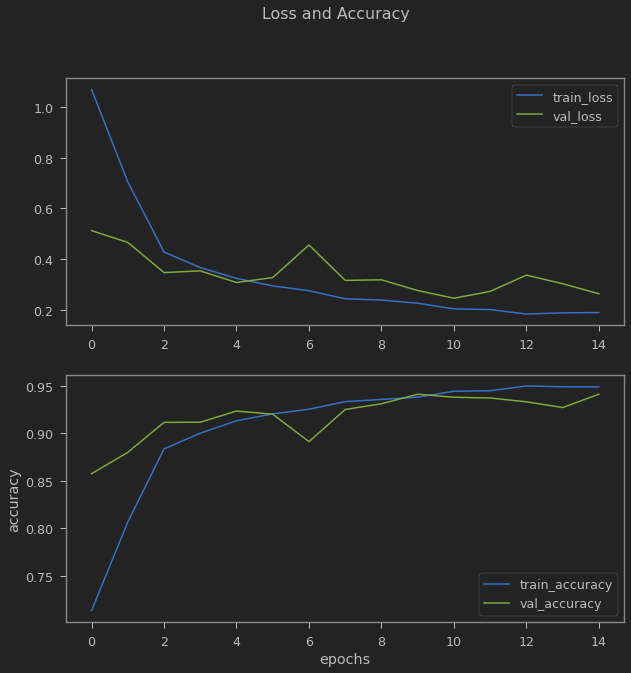

In [73]:
# Напечатаем лосс и точность
plot_loss_acc(history)

In [74]:
y_pred, actual_labels, preds_class, actual_class = get_all_preds(model,
                                                                 dataset=val_dataset)

In [75]:
plot_class_report(actual_class,preds_class)


                           precision    recall  f1-score   support

  abraham_grampa_simpson       0.92      0.98      0.95       274
           agnes_skinner       0.91      0.77      0.83        13
  apu_nahasapeemapetilon       0.96      0.96      0.96       187
           barney_gumble       0.56      0.84      0.68        32
            bart_simpson       0.98      0.96      0.97       403
            carl_carlson       0.89      0.86      0.88        29
charles_montgomery_burns       0.95      0.92      0.93       358
            chief_wiggum       0.95      0.95      0.95       296
         cletus_spuckler       0.83      0.71      0.77        14
          comic_book_guy       0.96      0.90      0.93       141
               disco_stu       0.67      1.00      0.80         2
          edna_krabappel       0.86      0.95      0.90       137
                fat_tony       0.60      0.38      0.46         8
                     gil       0.31      1.00      0.47         8
    gro

In [ ]:
# BATCH_SIZE = 128
# # DataLoader достаёт данные из dataset батчами
# dataloaders = {'train': DataLoader(balanced_train_dataset, batch_size=BATCH_SIZE, shuffle=True),
#                'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}

In [76]:
accurancy_for_each_class(actual_labels,y_pred)

Accuracy of abraham_grampa_simpson : 92 %
Accuracy of agnes_skinner : 90 %
Accuracy of apu_nahasapeemapetilon : 96 %
Accuracy of barney_gumble : 56 %
Accuracy of bart_simpson : 98 %
Accuracy of carl_carlson : 89 %
Accuracy of charles_montgomery_burns : 94 %
Accuracy of chief_wiggum : 94 %
Accuracy of cletus_spuckler : 83 %
Accuracy of comic_book_guy : 96 %
Accuracy of disco_stu : 66 %
Accuracy of edna_krabappel : 85 %
Accuracy of fat_tony : 60 %
Accuracy of   gil : 30 %
Accuracy of groundskeeper_willie : 82 %
Accuracy of homer_simpson : 91 %
Accuracy of kent_brockman : 94 %
Accuracy of krusty_the_clown : 98 %
Accuracy of lenny_leonard : 95 %
Accuracy of lionel_hutz : -1 %
Accuracy of lisa_simpson : 95 %
Accuracy of maggie_simpson : 100 %
Accuracy of marge_simpson : 98 %
Accuracy of martin_prince : 74 %
Accuracy of mayor_quimby : 88 %
Accuracy of milhouse_van_houten : 97 %
Accuracy of miss_hoover : 71 %
Accuracy of moe_szyslak : 98 %
Accuracy of ned_flanders : 98 %
Accuracy of nelson_mu

In [77]:
df_report = get_scores(df_report, actual_labels, y_pred,'Google_Net')
df_report

,F1_micro,F1_macro,precision_macro,recall_macro
Res_Net50,0.941083,0.859345,0.882896,0.872347
Google_Net,0.941242,0.833114,0.849765,0.863336


In [78]:
model_weights = copy.deepcopy(model.state_dict())
torch.save(model_weights, "./google_net_model_weights.pth")

In [ ]:
model.load_state_dict(torch.load("./google_net_model_weights.pth"))

### Тренировка модели_4

In [90]:
# Model
model, input_size = initialize_model(model_name[-1],n_classes,)

In [91]:
model = model.to(DEVICE)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [92]:
history = train(balanced_train_dataset,
                val_dataset,
                model=model,
                epochs=epochs,
                batch_size=batch_size)

epoch:   0%|                                                                                                                                                                                                                                                                                     | 0/15 [00:00<?, ?it/s]

Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 |  4% | 33% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 93% | 33% |
loss 0.884864475403771


epoch:   7%|█████████████████▊                                                                                                                                                                                                                                                          | 1/15 [03:12<44:54, 192.46s/it]


Epoch 001 train_loss: 0.8849     val_loss 0.3913 train_acc 0.7725 val_acc 0.8968
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 93% | 33% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 75% | 33% |
loss 0.6123843319125972


epoch:  13%|███████████████████████████████████▋                                                                                                                                                                                                                                        | 2/15 [06:14<40:22, 186.38s/it]


Epoch 002 train_loss: 0.6124     val_loss 0.3830 train_acc 0.8401 val_acc 0.9046
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 67% | 33% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 63% | 33% |
loss 0.3805958368674036


epoch:  20%|█████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 3/15 [09:14<36:39, 183.26s/it]


Epoch 003 train_loss: 0.3806     val_loss 0.3612 train_acc 0.8940 val_acc 0.9134
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 65% | 33% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 74% | 33% |
loss 0.33283172927826044


epoch:  27%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 4/15 [12:12<33:13, 181.27s/it]


Epoch 004 train_loss: 0.3328     val_loss 0.2948 train_acc 0.9098 val_acc 0.9303
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 82% | 33% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 62% | 33% |
loss 0.2942724343056746


epoch:  33%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                  | 5/15 [15:11<30:04, 180.44s/it]


Epoch 005 train_loss: 0.2943     val_loss 0.3172 train_acc 0.9205 val_acc 0.9291
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 81% | 33% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 74% | 34% |
loss 0.2875515003963271


epoch:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                | 6/15 [18:14<27:13, 181.47s/it]


Epoch 006 train_loss: 0.2876     val_loss 0.3931 train_acc 0.9218 val_acc 0.9073
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 82% | 34% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 77% | 34% |
loss 0.256845040626827


epoch:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 7/15 [21:28<24:43, 185.41s/it]


Epoch 007 train_loss: 0.2568     val_loss 0.2970 train_acc 0.9294 val_acc 0.9366
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 81% | 34% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 74% | 34% |
loss 0.248748814116879


epoch:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 8/15 [24:26<21:22, 183.20s/it]


Epoch 008 train_loss: 0.2487     val_loss 0.5609 train_acc 0.9325 val_acc 0.8780
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 82% | 33% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 78% | 33% |
loss 0.23389896600281299


epoch:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/15 [27:39<18:37, 186.20s/it]


Epoch 009 train_loss: 0.2339     val_loss 0.4084 train_acc 0.9379 val_acc 0.9134
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 83% | 33% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 67% | 33% |
loss 0.23739827654604517


epoch:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 10/15 [30:56<15:47, 189.41s/it]


Epoch 010 train_loss: 0.2374     val_loss 0.3127 train_acc 0.9379 val_acc 0.9333
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 84% | 33% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 77% | 33% |
loss 0.2195316925045565


epoch:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11/15 [34:12<12:46, 191.63s/it]


Epoch 011 train_loss: 0.2195     val_loss 0.3431 train_acc 0.9405 val_acc 0.9303
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 83% | 33% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 76% | 33% |
loss 0.22235002540124774


epoch:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 12/15 [37:29<09:39, 193.03s/it]


Epoch 012 train_loss: 0.2224     val_loss 0.4110 train_acc 0.9403 val_acc 0.9161
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 85% | 33% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 74% | 33% |
loss 0.1987396430098085


epoch:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 13/15 [40:28<06:18, 189.02s/it]


Epoch 013 train_loss: 0.1987     val_loss 0.3078 train_acc 0.9478 val_acc 0.9342
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 81% | 33% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 75% | 33% |
loss 0.2072674511171585


epoch:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 14/15 [43:32<03:07, 187.32s/it]


Epoch 014 train_loss: 0.2073     val_loss 0.3124 train_acc 0.9461 val_acc 0.9430
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 81% | 33% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 70% | 33% |
loss 0.19019891777061126


epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [46:34<00:00, 186.28s/it]


Epoch 015 train_loss: 0.1902     val_loss 0.3374 train_acc 0.9494 val_acc 0.9338


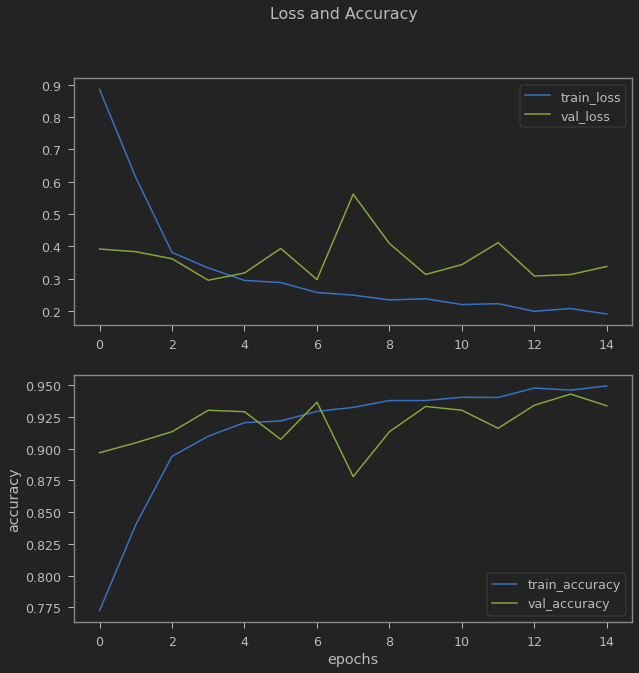

In [93]:
plot_loss_acc(history)

In [94]:
y_pred, actual_labels, preds_class, actual_class = get_all_preds(model,
                                                                 dataset=val_dataset)

In [95]:
plot_class_report(actual_class,preds_class)


                           precision    recall  f1-score   support

  abraham_grampa_simpson       0.99      0.90      0.94       274
           agnes_skinner       0.73      0.85      0.79        13
  apu_nahasapeemapetilon       1.00      0.90      0.95       187
           barney_gumble       0.83      0.78      0.81        32
            bart_simpson       0.99      0.95      0.97       403
            carl_carlson       0.79      0.93      0.86        29
charles_montgomery_burns       0.89      0.95      0.92       358
            chief_wiggum       0.91      0.96      0.93       296
         cletus_spuckler       1.00      0.64      0.78        14
          comic_book_guy       0.78      0.98      0.87       141
               disco_stu       1.00      1.00      1.00         2
          edna_krabappel       0.95      0.96      0.95       137
                fat_tony       1.00      0.88      0.93         8
                     gil       1.00      0.62      0.77         8
    gro

In [96]:
accurancy_for_each_class(actual_labels,y_pred)

Accuracy of abraham_grampa_simpson : 99 %
Accuracy of agnes_skinner : 73 %
Accuracy of apu_nahasapeemapetilon : 100 %
Accuracy of barney_gumble : 83 %
Accuracy of bart_simpson : 98 %
Accuracy of carl_carlson : 79 %
Accuracy of charles_montgomery_burns : 89 %
Accuracy of chief_wiggum : 90 %
Accuracy of cletus_spuckler : 100 %
Accuracy of comic_book_guy : 77 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 94 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 100 %
Accuracy of groundskeeper_willie : 96 %
Accuracy of homer_simpson : 96 %
Accuracy of kent_brockman : 84 %
Accuracy of krusty_the_clown : 99 %
Accuracy of lenny_leonard : 90 %
Accuracy of lionel_hutz : -1 %
Accuracy of lisa_simpson : 95 %
Accuracy of maggie_simpson : 83 %
Accuracy of marge_simpson : 97 %
Accuracy of martin_prince : 83 %
Accuracy of mayor_quimby : 71 %
Accuracy of milhouse_van_houten : 100 %
Accuracy of miss_hoover : 71 %
Accuracy of moe_szyslak : 89 %
Accuracy of ned_flanders : 87 %
Accuracy of nels

In [97]:
df_report = get_scores(df_report, actual_labels, y_pred,'Dense_Net')
df_report

,F1_micro,F1_macro,precision_macro,recall_macro
Res_Net50,0.941083,0.859345,0.882896,0.872347
Google_Net,0.941242,0.833114,0.849765,0.863336
Dense_Net,0.933758,0.854301,0.894499,0.852450


In [ ]:
model_weights = copy.deepcopy(model.state_dict())
torch.save(model_weights, "./Dense_net_model_weights.pth")

In [ ]:
model.load_state_dict(torch.load("./Dense_net_model_weights.pth"))

### Тренировка модели_3

In [108]:
# Model
model, input_size = initialize_model(model_name[1],n_classes,)

In [109]:
model = model.to(DEVICE)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [110]:
history = train(balanced_train_dataset,
                val_dataset,
                model=model,
                epochs=epochs,
                batch_size=batch_size)

epoch:   0%|                                                                                                                                                                                                                                                                                     | 0/15 [00:00<?, ?it/s]

Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 |  0% | 46% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 84% | 91% |
loss 1.1551697999172847


epoch:   7%|█████████████████▋                                                                                                                                                                                                                                                        | 1/15 [04:35<1:04:14, 275.32s/it]


Epoch 001 train_loss: 1.1552     val_loss 0.3795 train_acc 0.6951 val_acc 0.9006
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 91% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 91% |
loss 0.6443329650975012


epoch:  13%|███████████████████████████████████▋                                                                                                                                                                                                                                        | 2/15 [09:10<59:38, 275.28s/it]


Epoch 002 train_loss: 0.6443     val_loss 0.3769 train_acc 0.8331 val_acc 0.9097
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 91% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 91% |
loss 0.33848393165189095


epoch:  20%|█████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 3/15 [14:04<56:44, 283.67s/it]


Epoch 003 train_loss: 0.3385     val_loss 0.2369 train_acc 0.9106 val_acc 0.9432
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 91% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 85% | 90% |
loss 0.259745126727836


epoch:  27%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 4/15 [18:58<52:45, 287.78s/it]


Epoch 004 train_loss: 0.2597     val_loss 0.2109 train_acc 0.9312 val_acc 0.9525
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 81% | 90% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 90% |
loss 0.21959636372723954


epoch:  33%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                  | 5/15 [23:52<48:20, 290.10s/it]


Epoch 005 train_loss: 0.2196     val_loss 0.2191 train_acc 0.9400 val_acc 0.9514
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 90% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 72% | 90% |
loss 0.19891090647659593


epoch:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                | 6/15 [28:46<43:42, 291.39s/it]


Epoch 006 train_loss: 0.1989     val_loss 0.1984 train_acc 0.9462 val_acc 0.9578
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 90% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 78% | 90% |
loss 0.17149474691799033


epoch:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 7/15 [33:39<38:56, 292.09s/it]


Epoch 007 train_loss: 0.1715     val_loss 0.1674 train_acc 0.9537 val_acc 0.9658
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 90% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 85% | 90% |
loss 0.1578342423719535


epoch:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 8/15 [37:58<32:49, 281.33s/it]


Epoch 008 train_loss: 0.1578     val_loss 0.1852 train_acc 0.9573 val_acc 0.9600
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 94% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 93% |
loss 0.1430103436760217


epoch:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/15 [42:40<28:09, 281.62s/it]


Epoch 009 train_loss: 0.1430     val_loss 0.2003 train_acc 0.9608 val_acc 0.9608
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 93% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 71% | 93% |
loss 0.12709326694771994


epoch:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 10/15 [46:59<22:52, 274.57s/it]


Epoch 010 train_loss: 0.1271     val_loss 0.2477 train_acc 0.9669 val_acc 0.9519
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 93% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 93% |
loss 0.1259240575534633


epoch:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11/15 [51:25<18:08, 272.15s/it]


Epoch 011 train_loss: 0.1259     val_loss 0.1781 train_acc 0.9671 val_acc 0.9661
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 93% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 93% |
loss 0.1180006236689242


epoch:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 12/15 [56:11<13:48, 276.21s/it]


Epoch 012 train_loss: 0.1180     val_loss 0.1798 train_acc 0.9674 val_acc 0.9639
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 93% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 93% |
loss 0.11407456759277881


epoch:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 13/15 [1:00:56<09:17, 278.82s/it]


Epoch 013 train_loss: 0.1141     val_loss 0.1760 train_acc 0.9699 val_acc 0.9674
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 92% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 89% |
loss 0.10472251015411027


epoch:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 14/15 [1:05:41<04:40, 280.63s/it]


Epoch 014 train_loss: 0.1047     val_loss 0.2248 train_acc 0.9713 val_acc 0.9564
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 89% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 90% |
loss 0.09825611570123474


epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [1:10:14<00:00, 280.99s/it]


Epoch 015 train_loss: 0.0983     val_loss 0.2033 train_acc 0.9731 val_acc 0.9666


In [ ]:
# Посмотрим, какие слои мы будем обучать
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)

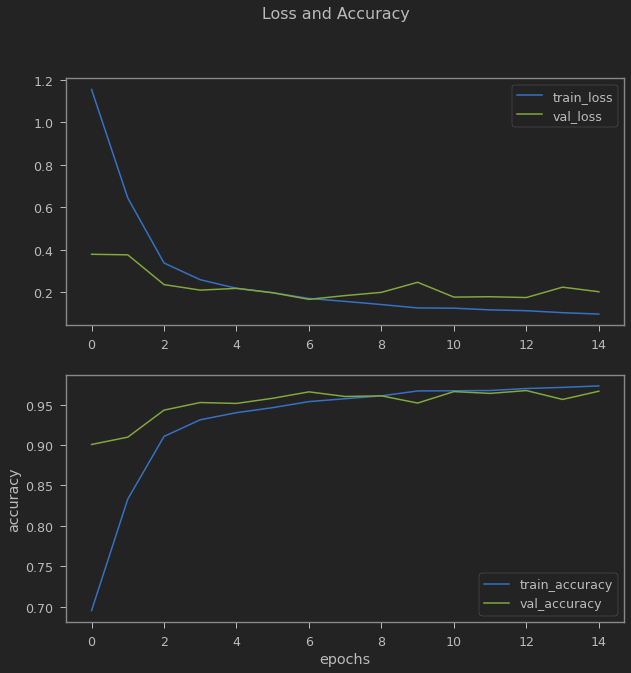

In [111]:
plot_loss_acc(history)

In [112]:
y_pred, actual_labels, preds_class, actual_class = get_all_preds(model,
                                                                 dataset=val_dataset)

In [113]:
plot_class_report(actual_class,preds_class)


                           precision    recall  f1-score   support

  abraham_grampa_simpson       0.99      0.97      0.98       274
           agnes_skinner       0.92      0.85      0.88        13
  apu_nahasapeemapetilon       1.00      0.96      0.98       187
           barney_gumble       0.85      0.88      0.86        32
            bart_simpson       0.95      0.99      0.97       403
            carl_carlson       0.93      0.93      0.93        29
charles_montgomery_burns       0.99      0.94      0.96       358
            chief_wiggum       1.00      0.94      0.97       296
         cletus_spuckler       0.72      0.93      0.81        14
          comic_book_guy       0.93      1.00      0.96       141
               disco_stu       0.67      1.00      0.80         2
          edna_krabappel       0.98      0.94      0.96       137
                fat_tony       0.89      1.00      0.94         8
                     gil       1.00      0.75      0.86         8
    gro

In [114]:
accurancy_for_each_class(actual_labels,y_pred)

Accuracy of abraham_grampa_simpson : 98 %
Accuracy of agnes_skinner : 91 %
Accuracy of apu_nahasapeemapetilon : 100 %
Accuracy of barney_gumble : 84 %
Accuracy of bart_simpson : 95 %
Accuracy of carl_carlson : 93 %
Accuracy of charles_montgomery_burns : 98 %
Accuracy of chief_wiggum : 100 %
Accuracy of cletus_spuckler : 72 %
Accuracy of comic_book_guy : 92 %
Accuracy of disco_stu : 66 %
Accuracy of edna_krabappel : 97 %
Accuracy of fat_tony : 88 %
Accuracy of   gil : 100 %
Accuracy of groundskeeper_willie : 81 %
Accuracy of homer_simpson : 98 %
Accuracy of kent_brockman : 96 %
Accuracy of krusty_the_clown : 96 %
Accuracy of lenny_leonard : 100 %
Accuracy of lionel_hutz : -1 %
Accuracy of lisa_simpson : 98 %
Accuracy of maggie_simpson : 97 %
Accuracy of marge_simpson : 98 %
Accuracy of martin_prince : 79 %
Accuracy of mayor_quimby : 94 %
Accuracy of milhouse_van_houten : 100 %
Accuracy of miss_hoover : 83 %
Accuracy of moe_szyslak : 94 %
Accuracy of ned_flanders : 91 %
Accuracy of nelso

Quantity of labels in validation dataset: 42
Quantity of predicted labels: 41


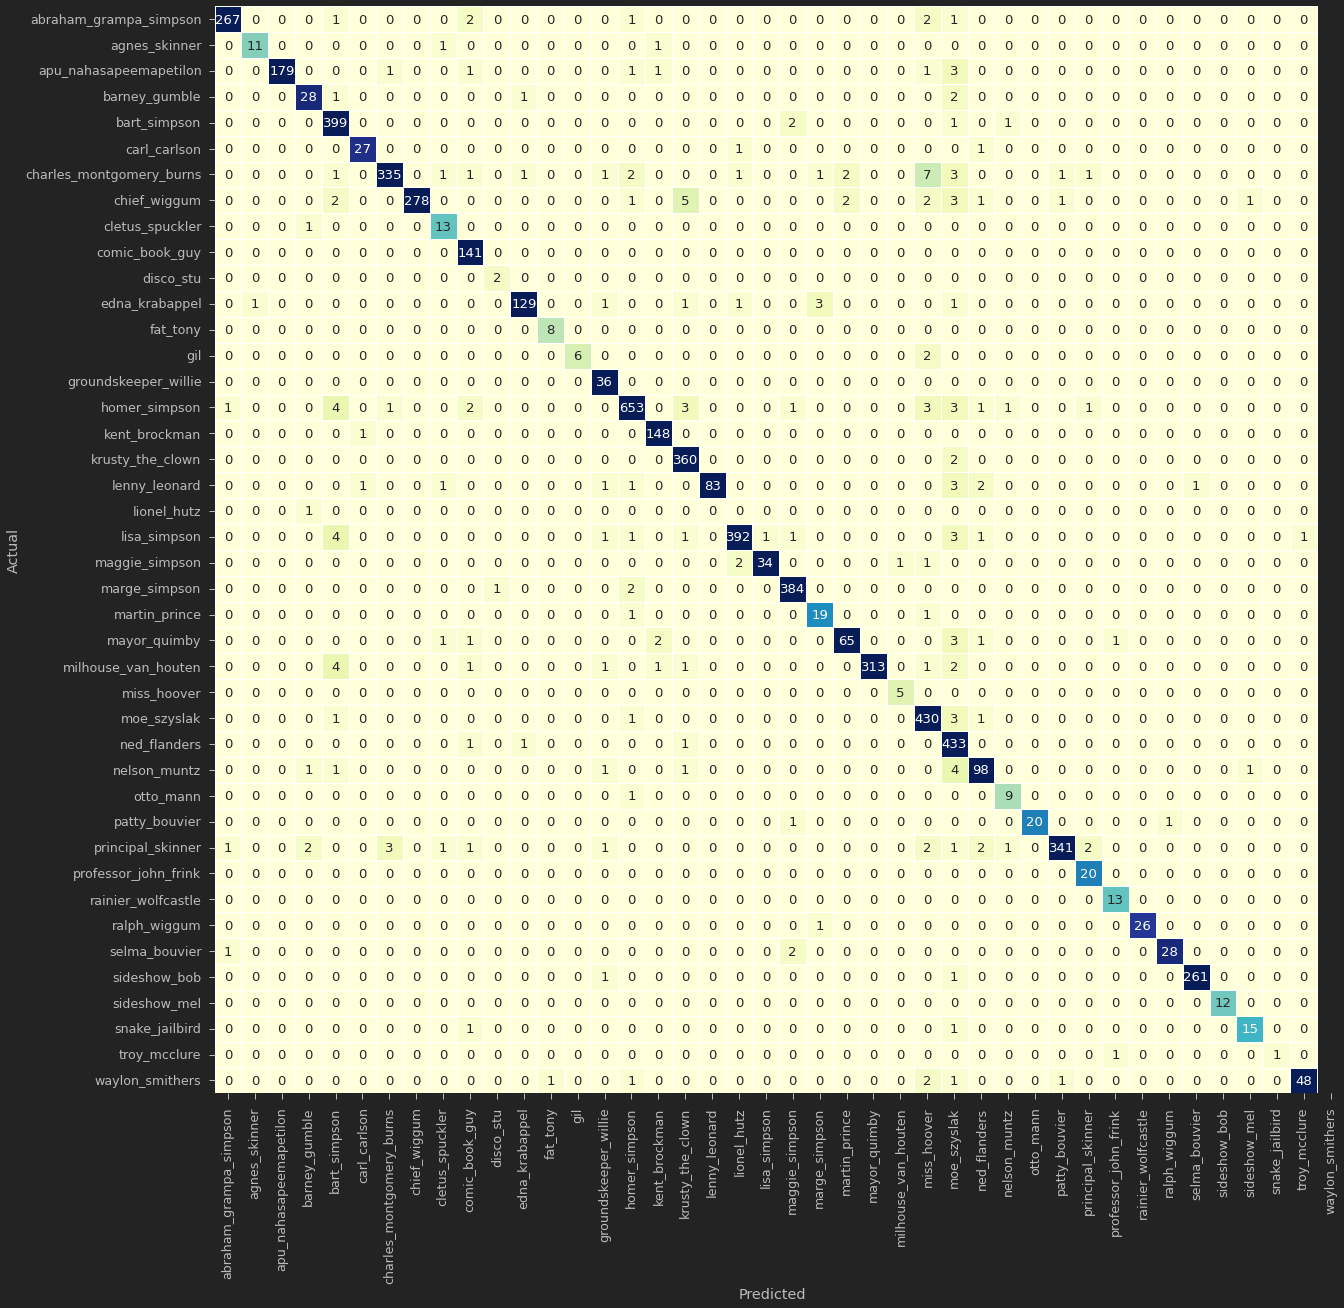

In [131]:
confusion_mtx(actual_class,preds_class)

In [115]:
df_report = get_scores(df_report, actual_labels, y_pred,'resnext-101')
df_report

,F1_micro,F1_macro,precision_macro,recall_macro
Res_Net50,0.941083,0.859345,0.882896,0.872347
Google_Net,0.941242,0.833114,0.849765,0.863336
Dense_Net,0.933758,0.854301,0.894499,0.852450
resnext-101,0.966561,0.904339,0.930468,0.912060


resnext-101 Показывает лучшие результаты. Используем ее для сабмита на кагл

In [125]:
model_weights = copy.deepcopy(model.state_dict())
torch.save(model_weights, "./resnext-101_model_weights.pth")

In [129]:
model.load_state_dict(torch.load("./resnext-101_model_weights.pth"))

<All keys matched successfully>

## Ансамбль

In [47]:
class MyEnsemble(nn.Module):   
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(n_classes * 2, n_classes)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x = torch.cat((x1, x2), dim=1)
        x = self.classifier(x)
        return x

In [48]:
# Укажем пути сохраненных весов моделей
path_res101 = "./resnext-101_model_weights.pth"
path_res50= "./Res_net_model_weights.pth"

In [49]:
# Реинициализируем модель
model_arch = model_name[0]
model_res50, input_size = initialize_model(model_arch,n_classes,)

In [50]:
# Реинициализируем модель
model_arch = model_name[1]
model_res101, input_size = initialize_model(model_arch,n_classes,)

In [52]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext101_32x8d', pretrained=True)

In [51]:
#  Загрузим параметры в модельки
model_res50.load_state_dict(torch.load(path_res50))
model_res101.load_state_dict(torch.load(path_res101))

<All keys matched successfully>

In [53]:
model_ensemble = MyEnsemble(model_res50,model_res101)

In [54]:
# замораживаем параметры (веса) не входящие в layers_to_unfreeze
for param in model_ensemble.parameters():
    param.requires_grad = False

for param in model_ensemble.classifier.parameters():
    param.requires_grad = True

In [74]:
# for param in model_ensemble.parameters():
#     if param.requires_grad == True:
#         print(param)

In [55]:
model_ensemble = model_ensemble.to(DEVICE)
print(model_ensemble)

MyEnsemble(
  (modelA): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [56]:
history = train(balanced_train_dataset,
                val_dataset,
                model=model_ensemble,
                epochs=epochs,
                batch_size=batch_size)

epoch:   0%|                                                                                                                    | 0/15 [00:00<?, ?it/s]

Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 |  4% | 31% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 31% |
loss 4.701549242923159


epoch:   7%|███████                                                                                                  | 1/15 [05:25<1:15:50, 325.06s/it]


Epoch 001 train_loss: 4.7015     val_loss 2.5270 train_acc 0.1653 val_acc 0.3892
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 90% | 31% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 30% |
loss 2.7320775964677035


epoch:  13%|██████████████                                                                                           | 2/15 [10:35<1:08:36, 316.68s/it]


Epoch 002 train_loss: 2.7321     val_loss 2.2107 train_acc 0.3769 val_acc 0.5283
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 30% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 30% |
loss 2.232974884314091


epoch:  20%|█████████████████████                                                                                    | 3/15 [15:49<1:03:05, 315.46s/it]


Epoch 003 train_loss: 2.2330     val_loss 1.3348 train_acc 0.4775 val_acc 0.6586
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 30% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 30% |
loss 1.8818743593422542


epoch:  27%|████████████████████████████▌                                                                              | 4/15 [20:34<55:35, 303.24s/it]


Epoch 004 train_loss: 1.8819     val_loss 1.1421 train_acc 0.5479 val_acc 0.7277
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 35% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 32% |
loss 1.6643971468119534


epoch:  33%|███████████████████████████████████▋                                                                       | 5/15 [25:28<49:59, 299.99s/it]


Epoch 005 train_loss: 1.6644     val_loss 1.4168 train_acc 0.5911 val_acc 0.6416
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 32% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 31% |
loss 1.5535811183192008


epoch:  40%|██████████████████████████████████████████▊                                                                | 6/15 [30:23<44:43, 298.22s/it]


Epoch 006 train_loss: 1.5536     val_loss 1.1218 train_acc 0.6178 val_acc 0.7111
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 31% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 86% | 29% |
loss 1.475622308552221


epoch:  47%|█████████████████████████████████████████████████▉                                                         | 7/15 [35:30<40:08, 301.05s/it]


Epoch 007 train_loss: 1.4756     val_loss 1.0319 train_acc 0.6434 val_acc 0.7583
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 88% | 29% |
GPU Usage after placing bunch of tensors in fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 29% |
loss 1.3344437467483576


epoch:  53%|█████████████████████████████████████████████████████████                                                  | 8/15 [40:46<35:40, 305.82s/it]


Epoch 008 train_loss: 1.3344     val_loss 0.8765 train_acc 0.6691 val_acc 0.7688
Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 87% | 29% |


epoch:  53%|█████████████████████████████████████████████████████████                                                  | 8/15 [43:55<38:25, 329.39s/it]


KeyboardInterrupt: 

Чет ниче не растет..... 

# Предсказания

In [126]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [127]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

findfont: Font family ['fantasy'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, Humor Sans, xkcd, fantasy


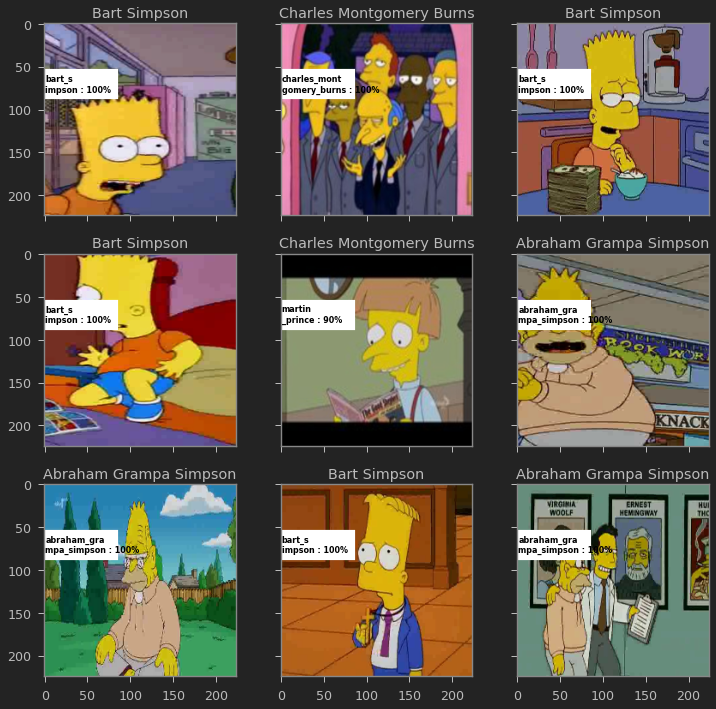

In [128]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Submission

In [116]:
test_dataset = SimpsonsDataset(test_files, mode="test",)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)
#probs = predict(model, test_loader)

In [117]:
# Создадим датасеты
test_dataset = SimpsonsDataset(test_files,
                                  mode='test', 
                                  transform=get_augmentation(224,'test'))


In [118]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [119]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)

In [120]:
probs = predict(model, test_loader)

In [121]:
preds = label_encoder.inverse_transform(np.argmax(probs, axis = 1 ))

In [122]:
test_filenames = [path.name for path in test_dataset.files]

In [123]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [124]:
my_submit.to_csv('RessXXX_net.csv', index=False)

# Вывод

### 0.97874 Очков На кагле

Во время выполнения было установленно, что добавление большего количества аугментаций положительно влияет на конечную точность.

Применение библиотеки Albumentations значительно ускорило время обработки и соотв. обучения.

В процессе обучения неоднократно возникали ошибки памяти CUDA. Применил несколько техник, рекоммендованных на просторах гугла, но это мне особо не помогло. Ошибки памяти вылазят рандомно. 

Хотел применить поиск Learning Rate, Но что-то пошло не так. Не доработал. 


In [98]:
torch.cuda.empty_cache()